In [17]:
import pandas as pd
import numpy as np
from sklearn import preprocessing 
from fancyimpute import KNN   
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.pipeline import Pipeline

In [2]:
train=pd.read_csv("../input/analytics-vidhya-loan-prediction/train.csv")
test=pd.read_csv("../input/analytics-vidhya-loan-prediction/test.csv")

In [3]:
train.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N


In [4]:
#Loan ID is dropped because it is not required
train=train.drop(["Loan_ID"],axis=1)
test=test.drop(["Loan_ID"],axis=1)

In [5]:
print(train.isnull().sum())

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [7]:
#Credit History and Loan Amount Term are categorical variables
train["Credit_History"]=train["Credit_History"].astype("object")

In [8]:
#KNN imputation
#Assigning levels to the categories
lis = []
for i in range(0, train.shape[1]):
    if(train.iloc[:,i].dtypes == 'object'):
        train.iloc[:,i] = pd.Categorical(train.iloc[:,i])
        train.iloc[:,i] = train.iloc[:,i].cat.codes 
        train.iloc[:,i] = train.iloc[:,i].astype('object')
        lis.append(train.columns[i])

In [9]:
#replace -1 with NA to impute
for i in range(0, train.shape[1]):
    train.iloc[:,i] = train.iloc[:,i].replace(-1, np.nan) 

In [10]:
#Apply KNN imputation algorithm
train = pd.DataFrame(KNN(k = 3).fit_transform(train), columns = train.columns)

Imputing row 1/614 with 1 missing, elapsed time: 0.083
Imputing row 101/614 with 0 missing, elapsed time: 0.088
Imputing row 201/614 with 0 missing, elapsed time: 0.090
Imputing row 301/614 with 0 missing, elapsed time: 0.091
Imputing row 401/614 with 0 missing, elapsed time: 0.093
Imputing row 501/614 with 0 missing, elapsed time: 0.094
Imputing row 601/614 with 2 missing, elapsed time: 0.096


In [11]:
#Convert into proper datatypes
for i in lis:
    train.loc[:,i] = train.loc[:,i].round()
    train.loc[:,i] = train.loc[:,i].astype('object')

In [12]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849.0,0.0,139.237669,360.0,1,2,1
1,1,1,1,0,0,4583.0,1508.0,128.000000,360.0,1,0,0
2,1,1,0,0,1,3000.0,0.0,66.000000,360.0,1,2,1
3,1,1,0,1,0,2583.0,2358.0,120.000000,360.0,1,2,1
4,1,0,0,0,0,6000.0,0.0,141.000000,360.0,1,2,1


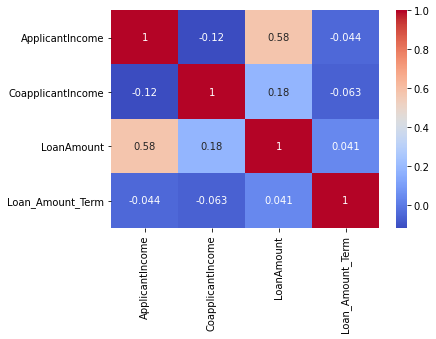

In [13]:
#Checking correlation between continuous variable
numvar=["ApplicantIncome","CoapplicantIncome","LoanAmount","Loan_Amount_Term"]
df_corr = train.loc[:,numvar]
sns.heatmap(df_corr.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')

In [14]:
#Standardizing the numerical variables
train["ApplicantIncome"]= (train["ApplicantIncome"] - train["ApplicantIncome"].mean())/train["ApplicantIncome"].std()
train["CoapplicantIncome"]= (train["CoapplicantIncome"] - train["CoapplicantIncome"].mean())/train["CoapplicantIncome"].std()
train["LoanAmount"]= (train["LoanAmount"] - train["LoanAmount"].mean())/train["LoanAmount"].std()
train["Loan_Amount_Term"]= (train["Loan_Amount_Term"] - train["Loan_Amount_Term"].mean())/train["Loan_Amount_Term"].std()

In [15]:
X=train.drop(["Loan_Status"],axis=1)
Y=train["Loan_Status"]
Y=Y.astype(int)
x=np.array(X)
y=np.array(Y)

In [19]:
decisiontree = tree.DecisionTreeClassifier()
pipe = Pipeline(steps=[('decisiontree', decisiontree)])
criterion = ['gini', 'entropy']
max_depth = list(range(1,20))
parameters = dict(decisiontree__criterion=criterion,decisiontree__max_depth=max_depth)
dt = GridSearchCV(pipe, parameters,cv=5,scoring="f1", n_jobs=-1)
dt.fit(x,y)
scores = cross_val_score(dt, x, y,scoring="f1", cv=5)
print("DT Cross validation f1 score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

DT Cross validation f1 score: 87.49% (+/- 3.38%)


In [21]:
#Naive Bayes
parameters = {'priors':[[0.01, 0.99],[0.1, 0.9], [0.2, 0.8], [0.25, 0.75], [0.3, 0.7],[0.35, 0.65], [0.4, 0.6],[0.45,0.55],[0.5,0.5],[0.55,0.45],[0.6,0.4]]}
nb = GridSearchCV(GaussianNB(), parameters, scoring = 'f1', n_jobs=-1)
nb.fit(x, y)
scores = cross_val_score(nb, x, y,scoring = 'f1', cv=5)
print("NB Cross validation F1 score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

NB Cross validation F1 score: 86.78% (+/- 3.62%)


In [23]:
number_of_neighbors = range(1,20)
params = {'n_neighbors':number_of_neighbors}
knn = KNeighborsClassifier()
knnmodel = GridSearchCV(knn, params, cv=5,scoring="f1", n_jobs=-1)
knnmodel.fit(x,y)
scores = cross_val_score(knnmodel, x, y,scoring="f1", cv=5)
print("KNN Cross validation f1 score: {0:.2%} (+/- {1:.2%})".format(np.mean(scores), np.std(scores)*2))

KNN Cross validation f1 score: 82.02% (+/- 2.59%)


Doing all the similar pre processing for test data

In [24]:
test["Credit_History"]=test["Credit_History"].astype("object")

In [25]:
#KNN imputation
#Assigning levels to the categories
lis = []
for i in range(0, test.shape[1]):
    if(test.iloc[:,i].dtypes == 'object'):
        test.iloc[:,i] = pd.Categorical(test.iloc[:,i])
        test.iloc[:,i] = test.iloc[:,i].cat.codes 
        test.iloc[:,i] = test.iloc[:,i].astype('object')
        lis.append(test.columns[i])

In [26]:
#replace -1 with NA to impute
for i in range(0, test.shape[1]):
    test.iloc[:,i] = test.iloc[:,i].replace(-1, np.nan) 

In [27]:
#Apply KNN imputation algorithm
test = pd.DataFrame(KNN(k = 3).fit_transform(test), columns = test.columns)

Imputing row 1/367 with 0 missing, elapsed time: 0.049
Imputing row 101/367 with 0 missing, elapsed time: 0.051
Imputing row 201/367 with 0 missing, elapsed time: 0.053
Imputing row 301/367 with 0 missing, elapsed time: 0.055


In [28]:
#Convert into proper datatypes
for i in lis:
    test.loc[:,i] = test.loc[:,i].round()
    test.loc[:,i] = test.loc[:,i].astype('object')

In [29]:
test["ApplicantIncome"]= (test["ApplicantIncome"] - test["ApplicantIncome"].mean())/test["ApplicantIncome"].std()
test["CoapplicantIncome"]= (test["CoapplicantIncome"] - test["CoapplicantIncome"].mean())/test["CoapplicantIncome"].std()
test["LoanAmount"]= (test["LoanAmount"] - test["LoanAmount"].mean())/test["LoanAmount"].std()
test["Loan_Amount_Term"]= (test["Loan_Amount_Term"] - test["Loan_Amount_Term"].mean())/test["Loan_Amount_Term"].std()

In [30]:
x=np.array(test)

In [31]:
#Prediction
ypred=dt.predict(x)

1: Y
0: N

In [32]:
test=pd.read_csv("../input/analytics-vidhya-loan-prediction/test.csv")
test["Loan_Status"]=ypred

In [33]:
dict = {0 : 'N', 1: 'Y'} 

In [34]:
test['Loan_Status']= test['Loan_Status'].map(dict) 

In [35]:
test.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [36]:
test=test.drop(['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],axis=1)

In [37]:
test.head()

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y


In [ ]:
test.to_csv("submissionfinal.csv")